In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Example cache directory path, it determines where downloaded data will be stored
output_dir = './ecephys_cache_dir/'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## Filter sessions data

In [2]:
filter_dict = {
    'session_type': 'brain_observatory_1.1',
    'full_genotype': 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
    'ecephys_structure_acronyms': 'VISp',
}

In [3]:
# sessions = cache.get_session_table()
# filtered_sessions = sessions[
#     np.logical_and.reduce([np.array([True if s in x else False for x in sessions[k]]) for k, s in filter_dict.items()])
# ]
# filtered_sessions

## Get session and probe

In [4]:
session_id = 721123822 # 797828357
session = cache.get_session_data(session_id)

In [5]:
probes = session.probes
channels = session.channels
channels = channels.loc[channels['structure_acronym'] == filter_dict['ecephys_structure_acronyms']]
len(channels)

81

In [6]:
probe_id = channels.probe_id.unique()
probe_id

array([760213145], dtype=int64)

In [7]:
probe_id = probe_id[0]
channel_id = 850245985
probe = probes.loc[probe_id]

In [8]:
fs = probe.lfp_sampling_rate

### Save data in selected channels

#### Average channels in groups

In [9]:
# import sklearn as sk
# from sklearn import manifold, cluster

# ccf_coords = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
# channel_coord = channels[ccf_coords].values

# # reduce dimension to one
# method = 'ltsa' # 'standard' 'hessian' 'ltsa' 'modified'
# lle = manifold.LocallyLinearEmbedding(n_components=1, n_neighbors=6, method=method)
# probe_coord = lle.fit_transform(channel_coord) # 1D coordinate of channels

# # find number of clusters in the channels
# probe_coord = sk.preprocessing.MinMaxScaler().fit_transform(probe_coord)
# kmeans = cluster.KMeans(2, n_init='auto')
# jumps = kmeans.fit_predict(np.diff(np.sort(probe_coord, axis=0), axis=0))
# n_group = np.sum(jumps == np.argmax(kmeans.cluster_centers_.ravel())) + 1

# # divide channels into groups
# kmeans = cluster.KMeans(n_group, n_init='auto')
# channel_group = kmeans.fit_predict(probe_coord)
# group_centers = kmeans.cluster_centers_.ravel()
# group_sort_id = np.argsort(group_centers)

# # visualize channel groups
# plt.figure(figsize=(5, 4))
# for g, x in zip(channel_group, probe_coord.ravel()):
#     plt.plot(group_centers[g], x, 'b.', markersize=2)
# plt.show()

In [10]:
# # Load LFP given probe
# lfp_array = session.get_lfp(probe_id)
# lfp_array = lfp_array.sel(channel=np.unique(lfp_array.channel.sel(channel=channels.index, method='nearest')))

# # Compile groups of channels
# channels_group_id = np.zeros(channel_group.size, dtype=int)
# channels_in_groups = {}
# group_ccf_coord = np.zeros((n_group, 3))
# for i in range(n_group):
#     idx = channel_group == group_sort_id[i]
#     channels_group_id[idx] = i
#     group_ccf_coord[i, :] = channels[idx][ccf_coords].values.mean(axis=0)
#     channels_in_groups[i] = channels[idx].index.values
# channel_group_map = pd.DataFrame(channels_group_id, columns=['group_id'], index=channels.index)
# channel_group_map[ccf_coords] = group_ccf_coord[channels_group_id]
# for g, c in channels_in_groups.items():
#     channels_in_groups[g] = np.array([x for x in c if x in lfp_array.channel])

# # Create group average LFP dataset
# channel_group_ids = pd.Index(np.arange(n_group), name='group_id')
# group_lfp = [lfp_array.sel(channel=channels_in_groups[i]).mean(dim='channel') for i in channel_group_ids]
# group_lfp = xr.concat(group_lfp, dim=channel_group_ids).to_dataset(name='LFP')

# # Save data
# filepath = os.path.join(output_dir, 'session_%d' % session_id,
#                         'lfp_probe%d_%s_channel_groups.nc' % (probe_id, filter_dict['ecephys_structure_acronyms']))
# group_lfp.to_netcdf(filepath) # save downsampled channels
# channel_group_map.to_csv(filepath.replace('.nc', '.csv'))
# group_lfp

#### Save one particular channel

In [11]:
# lfp = session.get_lfp(probe_id).sel(channel=channel_id, method='nearest')
# filepath = os.path.join(output_dir, 'session_%d' % session_id, 'lfp_probe%d_channel%d.nc' % (probe_id, channel_id))
# lfp.to_netcdf(filepath)
# lfp

### Load channel

In [12]:
filepath = os.path.join(output_dir, 'session_%d' % session_id,
                        'lfp_probe%d_%s_channel_groups.nc' % (probe_id, filter_dict['ecephys_structure_acronyms']))
lfp_array = xr.open_dataset(filepath)
lfp_array = lfp_array.assign_attrs(fs=fs).rename(group_id='channel')
lfp_array

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 ...
Attributes:
    fs:       1249.99999145772

In [13]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
group_dv_ccf = dict(zip(channel_group_map['group_id'], channel_group_map['dorsal_ventral_ccf_coordinate']))
group_id = channel_group_map.loc[channel_id, 'group_id']
channel_group_map

,group_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate
id,,,,
850245925,7,8545.625000,1435.500000,8019.625000
850245931,7,8545.625000,1435.500000,8019.625000
850245937,7,8545.625000,1435.500000,8019.625000
850245943,6,8575.875000,1347.250000,8024.875000
850245949,6,8575.875000,1347.250000,8024.875000
...,...,...,...,...
850246077,0,8844.181818,583.363636,8054.818182
850246079,0,8844.181818,583.363636,8054.818182
850246081,0,8844.181818,583.363636,8054.818182


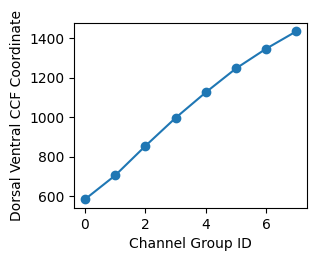

In [14]:
plt.figure(figsize=(3, 2.4))
plt.plot(group_dv_ccf.keys(), group_dv_ccf.values(), marker='o')
plt.xlabel('Channel Group ID')
plt.ylabel('Dorsal Ventral CCF Coordinate')
plt.show()

## Analysis

In [15]:
stimulus_presentations = session.stimulus_presentations

In [16]:
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

def fit_fooof(f, pxx, aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10,
              freq_range=None, peak_width_limits=None, report=False,
              plot=False, plt_log=False, plt_range=None, figsize=None):
    if aperiodic_mode != 'knee':
        aperiodic_mode = 'fixed'
    def set_range(x, upper=f[-1]):        
        x = np.array(upper) if x is None else np.array(x)
        return [f[2], x.item()] if x.size == 1 else x.tolist()
    freq_range = set_range(freq_range)
    peak_width_limits = set_range(peak_width_limits, np.inf)

    # Initialize a FOOOF object
    fm = FOOOF(peak_width_limits=peak_width_limits, min_peak_height=dB_threshold / 10,
               peak_threshold=0., max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode)
    # Fit the model
    fm.fit(f, pxx, freq_range)
    results = fm.get_results()

    if report:
        fm.print_results()
        if aperiodic_mode=='knee':
            ap_params = results.aperiodic_params
            if ap_params[1] <= 0:
                print('Negative value of knee parameter occurred. Suggestion: Fit without knee parameter.')
            knee_freq = np.abs(ap_params[1]) ** (1 / ap_params[2])
            print(f'Knee location: {knee_freq:.2f} Hz')
    if plot:
        plt_range = set_range(plt_range)
        fm.plot(plt_log=plt_log)
        plt.xlim(np.log10(plt_range) if plt_log else plt_range)
        if figsize:
            plt.gcf().set_size_inches(figsize)
        ax = plt.gca()
        ax.legend(fontsize='medium', framealpha=0.2)
        ax.xaxis.label.set_size('medium')
        ax.yaxis.label.set_size('medium')
        ax.tick_params(labelsize='medium')
        plt.show()
    return results, fm

def trial_averaged_psd(aligned_lfp, tseg=1.):
    fs = aligned_lfp.fs
    trial_duration = aligned_lfp.time_from_presentation_onset[-1] - aligned_lfp.time_from_presentation_onset[0]
    nperseg = int(np.ceil(trial_duration / max(np.round(trial_duration / tseg), 1) * fs))
    f, pxx = sp.signal.welch(aligned_lfp.LFP, fs=fs, nperseg=nperseg)
    psd_array = xr.DataArray(pxx, coords={
        'channel': aligned_lfp.channel, 'presentation_id': aligned_lfp.presentation_id, 'frequency': f
    }).to_dataset(name='PSD')
    return psd_array.mean(dim='presentation_id')

def plot_channel_psd(psd_avg, channel_id=None, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                 aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True):
    psd_avg_plt = psd_avg.sel(frequency=slice(*plt_range))
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.get_cmap('plasma')(np.linspace(0, 1, psd_avg.dims['channel'])))
    plt.figure(figsize=figsize)
    plt.plot(psd_avg_plt.frequency, psd_avg_plt.PSD.T, label=psd_avg_plt.channel.values)
    plt.xlim(plt_range)
    plt.yscale('log')
    plt.legend(loc='upper right', framealpha=0.2)
    plt.show()

    if channel_id is None:
        channel_id = lfp_array.channel[0]
    print(f'Channel: {channel_id: d}')
    psd_avg_plt = psd_avg.sel(channel=channel_id)
    results = fit_fooof(psd_avg_plt.frequency.values, psd_avg_plt.PSD.values,
                        aperiodic_mode=aperiodic_mode, dB_threshold=dB_threshold, max_n_peaks=max_n_peaks,
                        freq_range=freq_range, peak_width_limits=None, report=True,
                        plot=True, plt_log=plt_log, plt_range=plt_range[1], figsize=figsize)
    return results

def trial_averaged_spectrogram(aligned_lfp, tseg=1.):
    fs = aligned_lfp.fs
    trial_duration = aligned_lfp.time_from_presentation_onset[-1] - aligned_lfp.time_from_presentation_onset[0]
    nperseg = int(np.ceil(trial_duration / max(np.round(trial_duration / tseg), 1) * fs))
    f, t, sxx = sp.signal.spectrogram(aligned_lfp.LFP, fs=fs, nperseg=nperseg)
    sxx_array = xr.DataArray(sxx, coords={
        'channel': aligned_lfp.channel, 'presentation_id': aligned_lfp.presentation_id, 'frequency': f, 'time': t
    }).to_dataset(name='PSD')
    return sxx_array.mean(dim='presentation_id')

def plot_spectrogram(sxx_xarray, remove_aperiodic=None, plt_log=False,
                     plt_range=None, clr_freq_range=None, ax=None):
    sxx = sxx_xarray.PSD.values.copy()
    t = sxx_xarray.time.values.copy()
    f = sxx_xarray.frequency.values.copy()

    cbar_label = 'PSD' if remove_aperiodic is None else 'PSD Residual'
    if plt_log:
        with np.errstate(divide='ignore'):
            sxx = np.log10(sxx)
        cbar_label += ' log(power)'

    if remove_aperiodic is not None:
        ap_fit = gen_aperiodic(f[1:], remove_aperiodic.aperiodic_params)
        sxx[1:, :] -= (ap_fit if plt_log else 10 ** ap_fit)[:, None]
        sxx[0, :] = 0.

    if ax is None:
        _, ax = plt.subplots(1, 1)
    plt_range = np.array(f[-1]) if plt_range is None else np.array(plt_range)
    if plt_range.size == 1:
        plt_range = [f[1] if plt_log else 0., plt_range.item()]
    f_idx = (f >= plt_range[0]) & (f <= plt_range[1])
    if clr_freq_range is None:
        vmin, vmax = None, None
    else:
        c_idx = (f >= clr_freq_range[0]) & (f <= clr_freq_range[1])
        vmin, vmax = sxx[c_idx, :].min(), sxx[c_idx, :].max()

    pcm = ax.pcolormesh(t, f[f_idx], sxx[f_idx, :], shading='gouraud', vmin=vmin, vmax=vmax)
    ax.set_ylim(plt_range)
    plt.colorbar(mappable=pcm, ax=ax, label=cbar_label)
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Frequency (Hz)')
    return sxx

def plot_channel_spectrogram(sxx_avg, channel_id=None, plt_range=(0, 100.), plt_log=True,
                             clr_freq_range=None, figsize=(6, 3.6),
                             remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'}):
    if channel_id is None:
        channel_id = sxx_avg.channel.values
    else:
        channel_id = np.asarray(channel_id)
        if not channel_id.ndim:
            channel_id = channel_id.reshape(1)
    if remove_aperiodic is None:
        fooof_results = None

    _, axs = plt.subplots(channel_id.size, 1, squeeze=False, figsize=(figsize[0], channel_id.size * figsize[1]))
    for channel, ax in zip(channel_id, axs.ravel()):
        sxx_single = sxx_avg.sel(channel=channel)
        if remove_aperiodic is not None:
            sxx_tot = sxx_single.mean(dim='time')
            fooof_results, _ = fit_fooof(sxx_tot.frequency.values, sxx_tot.PSD.values, **remove_aperiodic)
        _ = plot_spectrogram(sxx_single, remove_aperiodic=fooof_results, plt_log=plt_log,
                             plt_range=plt_range, clr_freq_range=clr_freq_range, ax=ax)
        ax.set_title(f'channel {channel: d}')
    plt.tight_layout()
    plt.show()

In [17]:
def align_trials(lfp_array, onset_times, presentation_ids, window=(0., 1.)):
    trial_window = np.arange(window[0], window[1], 1 / lfp_array.fs)
    time_selection = np.concatenate([trial_window + t for t in onset_times])
    inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))
    aligned_lfp = lfp_array.sel(time=time_selection, method='nearest')
    aligned_lfp = aligned_lfp.assign(time=inds).unstack('time')
    return aligned_lfp

def align_gratings(lfp_array, stimulus_presentations, stimulus_name='drifting_gratings'):
    gratings_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    null_rows = gratings_presentations[gratings_presentations['orientation'].values == 'null']
    if len(null_rows):
        null_condition = null_rows.iloc[0]['stimulus_condition_id']
        gratings_presentations = gratings_presentations[gratings_presentations['stimulus_condition_id'] != null_condition]

    gratings_times = gratings_presentations['start_time'].values
    gratings_ids = gratings_presentations.index.values
    trial_duration = gratings_presentations['duration'].max()
    return align_trials(lfp_array, gratings_times, gratings_ids, window=(0., trial_duration))

def align_scenes(lfp_array, stimulus_presentations, stimulus_name='natural_scenes'):
    natural_scenes_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    null_rows = natural_scenes_presentations[natural_scenes_presentations['frame'].values < 0]
    if len(null_rows):
        null_condition = null_rows.iloc[0]['stimulus_condition_id']
        natural_scenes_presentations = natural_scenes_presentations[natural_scenes_presentations['stimulus_condition_id'] != null_condition]

    natural_scenes_times = natural_scenes_presentations['start_time'].values
    natural_scenes_ids = natural_scenes_presentations.index.values
    trial_duration = natural_scenes_presentations['duration'].max()
    return align_trials(lfp_array, natural_scenes_times, natural_scenes_ids, window=(0., trial_duration))

def align_movie(lfp_array, stimulus_presentations, stimulus_name='natural_movie_one'):
    natural_movie_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == stimulus_name]
    frame_ids = natural_movie_presentations['stimulus_condition_id'].unique()

    natural_movie_times = natural_movie_times = np.column_stack([
        natural_movie_presentations[natural_movie_presentations['stimulus_condition_id'] == frame_ids[0]]['start_time'].values,
        natural_movie_presentations[natural_movie_presentations['stimulus_condition_id'] == frame_ids[-1]]['stop_time'].values,
    ])
    natural_movie_ids = natural_movie_presentations[natural_movie_presentations['stimulus_condition_id'] == frame_ids[0]].index.values
    trial_duration = np.diff(natural_movie_times, axis=1).max()
    return align_trials(lfp_array, natural_movie_times[:, 0], natural_movie_ids, window=(0., trial_duration))

### drifting_gratings

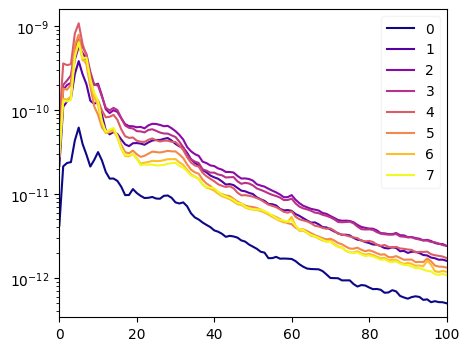

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.6166, 69.2671, 2.0629                                     
                                                                                                  
                                       2 peaks were found:                                       

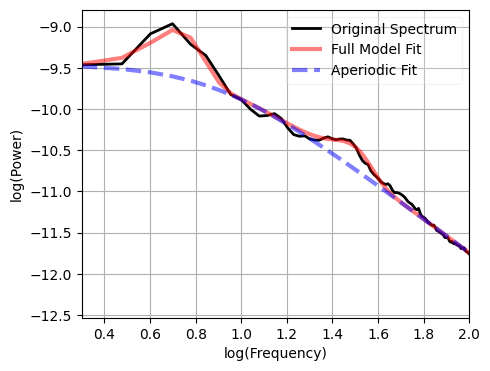

In [18]:
aligned_lfp = align_gratings(lfp_array, stimulus_presentations, stimulus_name='drifting_gratings')
psd_avg = trial_averaged_psd(aligned_lfp, tseg=1.)
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

### static_gratings

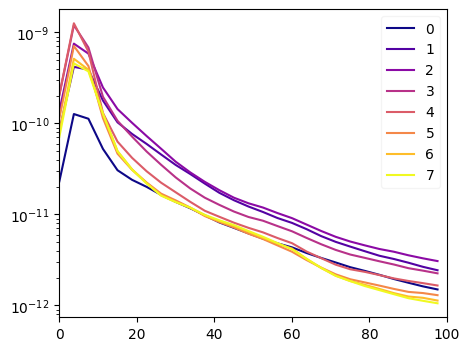

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 199 Hz                        
                                 Frequency Resolution is 3.75 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.7921, 1.9907                                          
                                                                                                  
                                       0 peaks were found:                                       

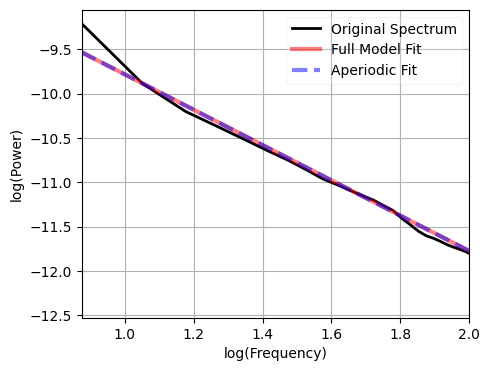

In [19]:
aligned_lfp = align_gratings(lfp_array, stimulus_presentations, stimulus_name='static_gratings')
psd_avg = trial_averaged_psd(aligned_lfp, tseg=1.)
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10, plt_log=True)

### natural_scenes

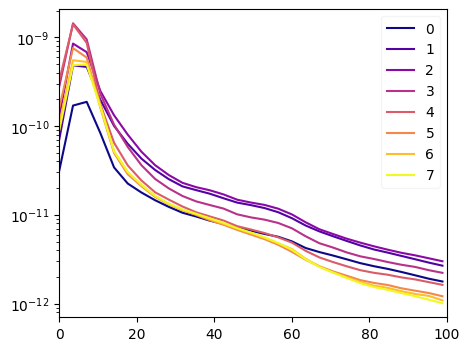

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 198 Hz                        
                                 Frequency Resolution is 3.53 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.9644, 1.8940                                          
                                                                                                  
                                       0 peaks were found:                                       

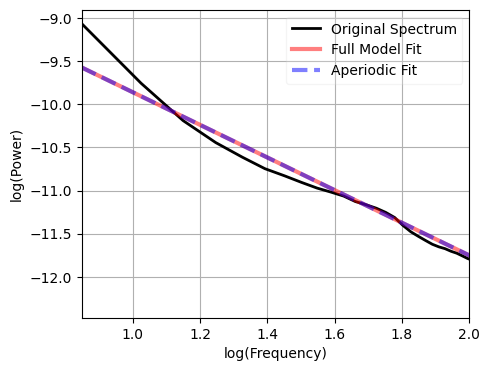

In [20]:
aligned_lfp = align_scenes(lfp_array, stimulus_presentations, stimulus_name='natural_scenes')
psd_avg = trial_averaged_psd(aligned_lfp, tseg=1.)
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10, plt_log=True)

### natural_movie_one

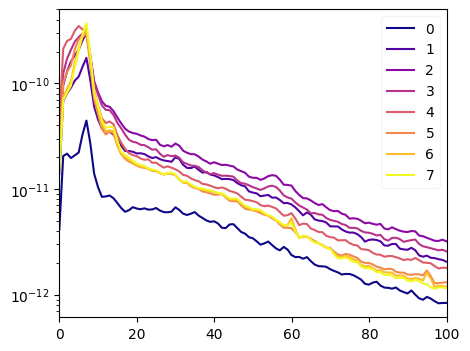

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.2550, 24.8636, 1.7377                                     
                                                                                                  
                                       1 peaks were found:                                       

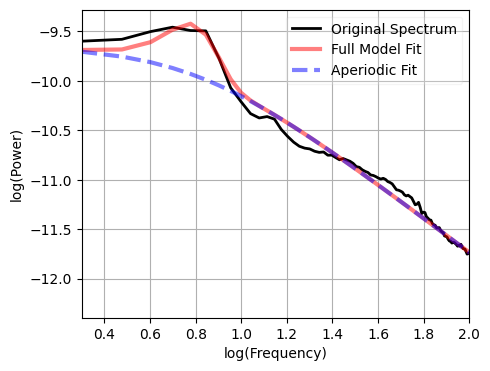

In [21]:
aligned_lfp = align_movie(lfp_array, stimulus_presentations, stimulus_name='natural_movie_one')
psd_avg = trial_averaged_psd(aligned_lfp, tseg=1.)
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

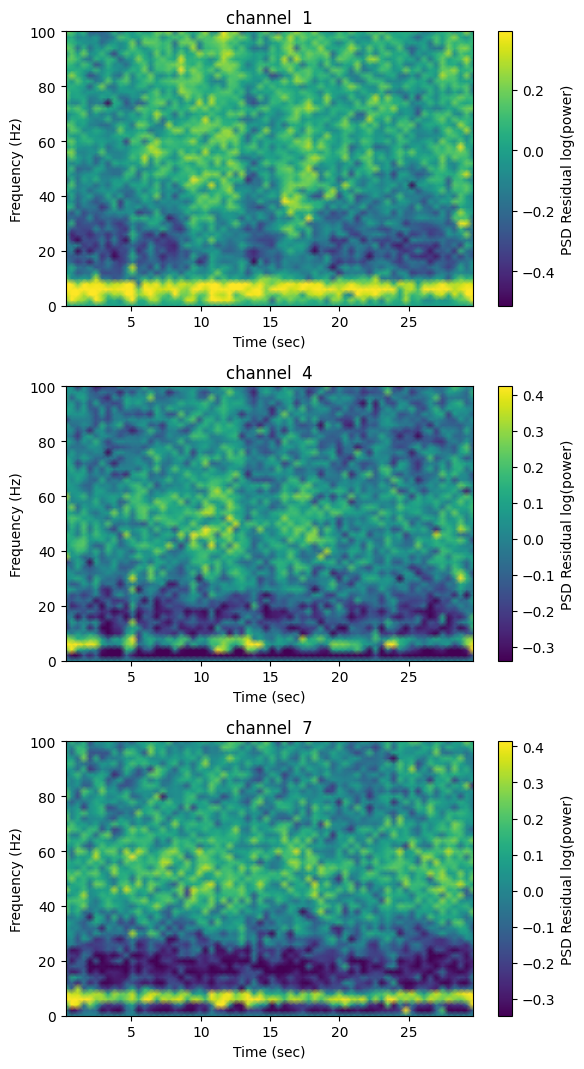

In [22]:
sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
plot_channel_spectrogram(sxx_avg, channel_id=[1, 4, 7], plt_range=(0, 100.), plt_log=True,
                         clr_freq_range=(30., 80.), figsize=(6, 3.6),
                         remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'})

### natural_movie_three

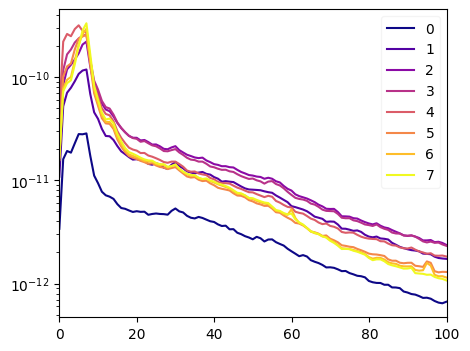

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.3901, 16.1071, 1.6625                                     
                                                                                                  
                                       1 peaks were found:                                       

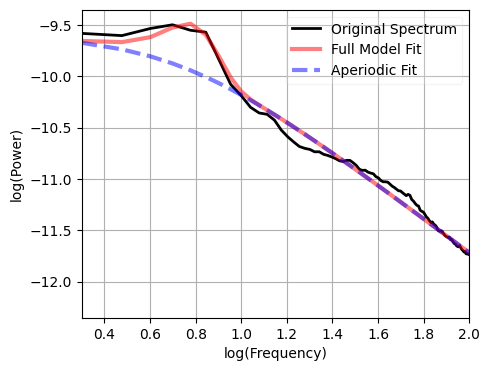

In [23]:
aligned_lfp = align_movie(lfp_array, stimulus_presentations, stimulus_name='natural_movie_three')
psd_avg = trial_averaged_psd(aligned_lfp, tseg=1.)
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

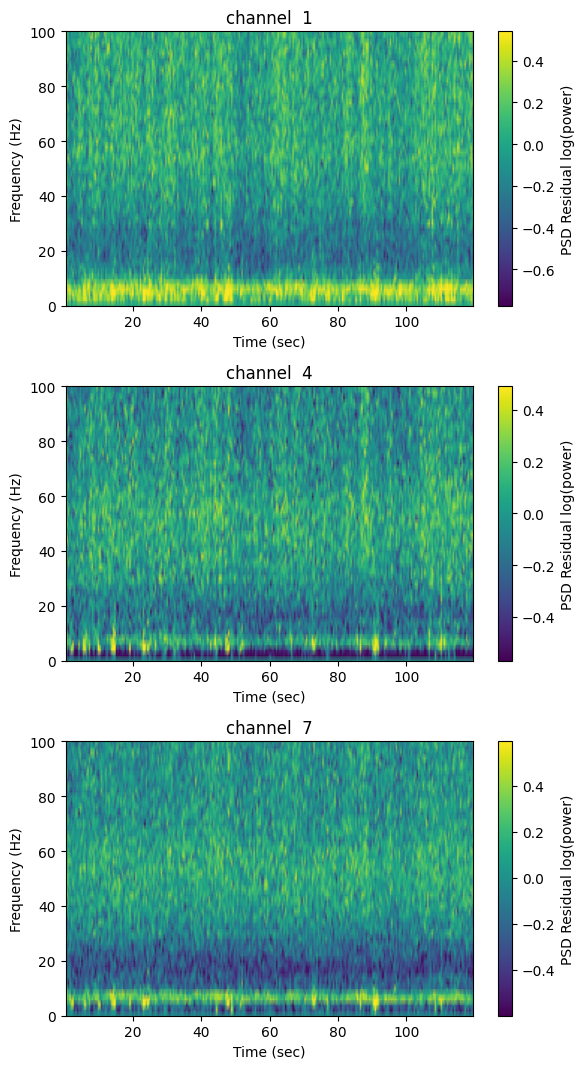

In [24]:
sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
plot_channel_spectrogram(sxx_avg, channel_id=[1, 4, 7], plt_range=(0, 100.), plt_log=True,
                         clr_freq_range=(30., 80.), figsize=(6, 3.6),
                         remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'})